,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


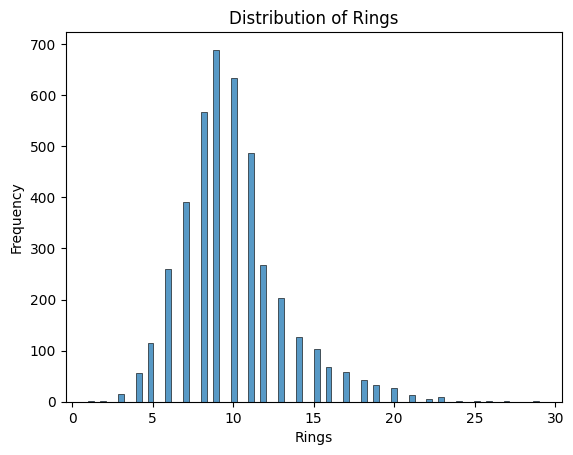

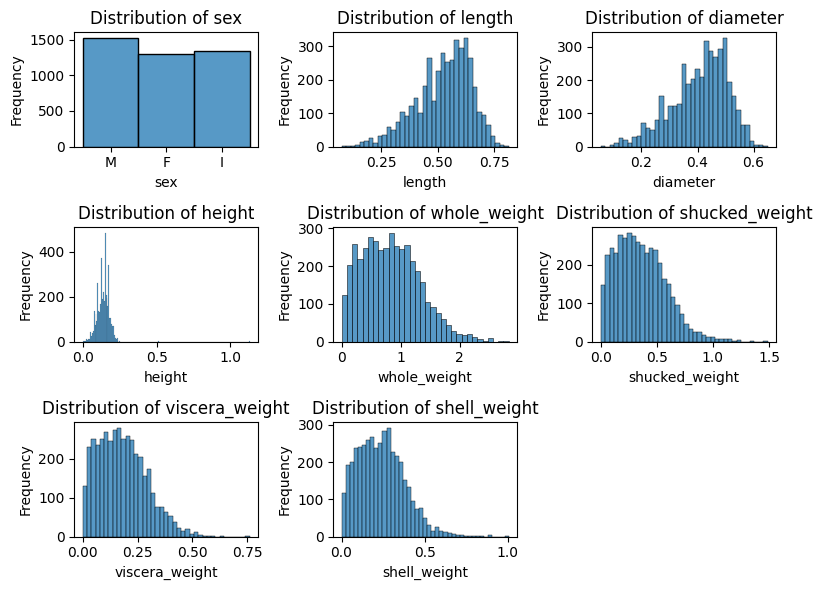

In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Abalone dataset
abalone = fetch_ucirepo(id = 1)

X = abalone.data.features
y = abalone.data.targets #rings

#Variable names originally uppercase, switching to lowercase for ease
X.columns = X.columns.str.lower()
y.columns = y.columns.str.lower()

abalone_df = X.join(y)
display(abalone_df.head())

#Target distribution
sns.histplot(y['rings'])
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

#Feature distribution
plt.figure(figsize=(8, 6))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Rings distribution indicates that the average abalone in this dataset has between 8-11 rings, meaning 9.5 to 12.5 years of age (this conversion from rings to age was provided in the dataset information).

Looking at the distributions, all of the weight variables are right-skewed. Height has a few observations that are much larger than where most of the observations lie, implying outlying large abalone or even improper measurement. Intuitively, the weight variables should be investigated for multicollinearity.

Sex as a categorical variable seems relatively evenly spread, with slightly more male observations than female and infant. Length and diameter are both left-skewed and the histograms seem to follow a very similar shape to each other, implying collinearity.

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


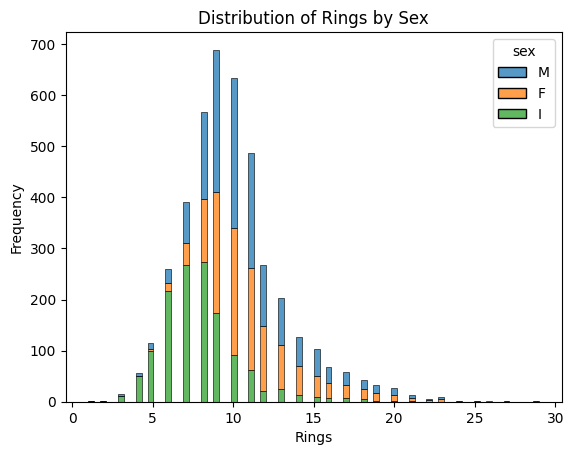

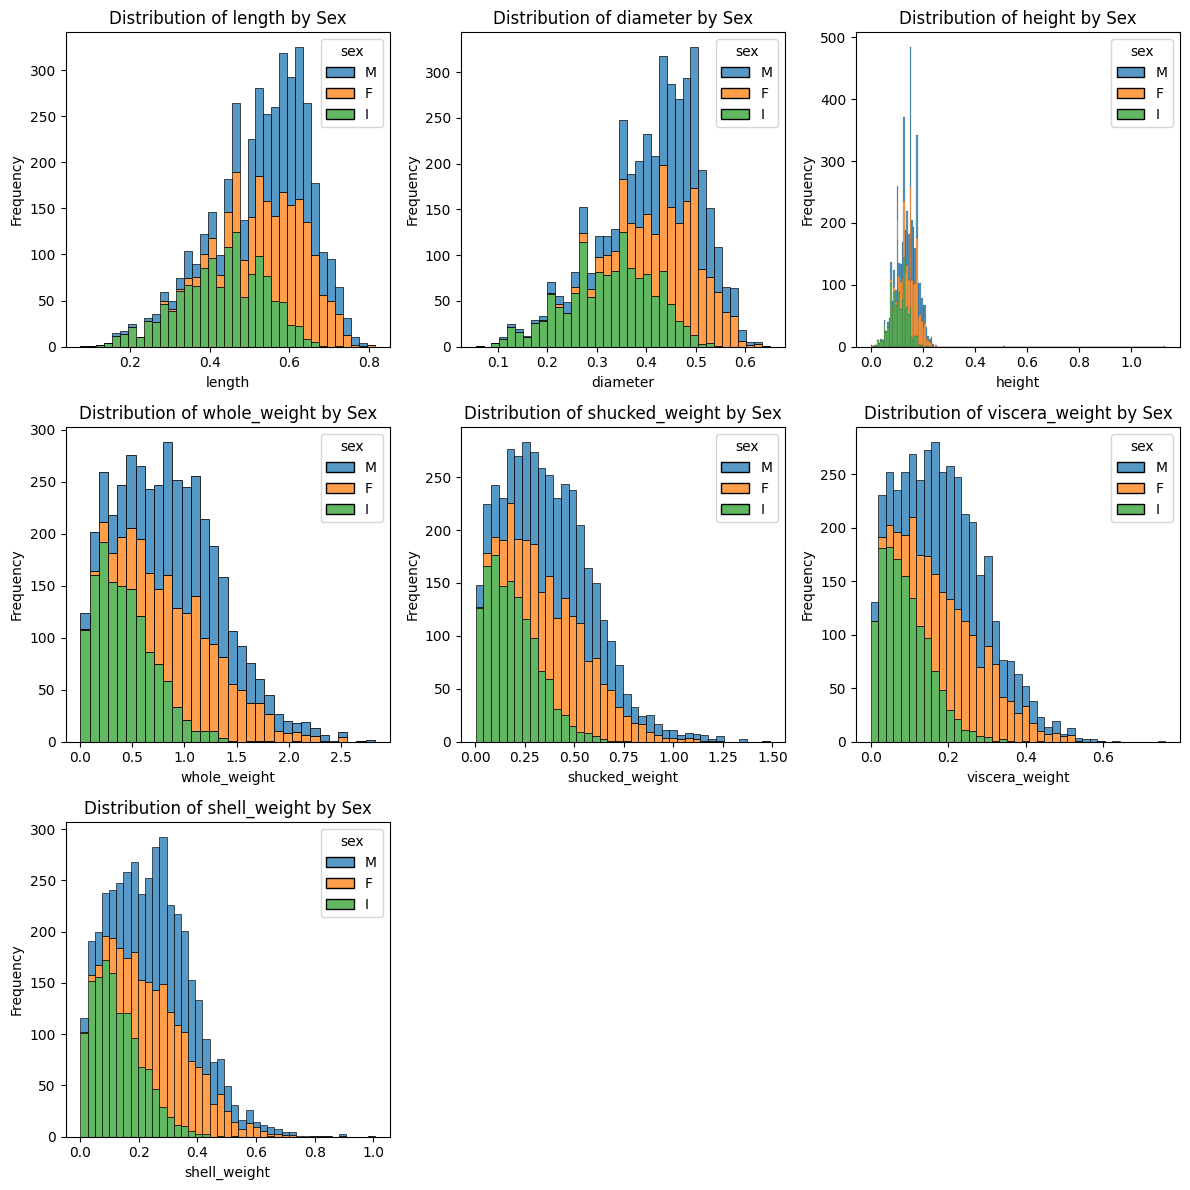

In [ ]:
#Distribution of target (rings) by sex
sns.histplot(data = abalone_df, x = 'rings', hue = 'sex', multiple = 'stack')
plt.title('Distribution of Rings by Sex')
plt.xlabel('Rings')
plt.ylabel('Frequency')

#Distribution of features by sex
features_minus_sex = X[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']]

display(features_minus_sex.head())

plt.figure(figsize=(12, 12))
for i, column in enumerate(features_minus_sex.columns):
  plt.subplot(3, 3, i + 1)
  sns.histplot(data = abalone_df, x = column, hue = 'sex', multiple = 'stack')
  plt.title(f'Distribution of {column} by Sex')
  plt.xlabel(column)
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As expected, infant abalone tend to score lower in every metric regarding weight and size. This can be useful during classification for determining whether a given abalone is ready to be harvested, as many states/countries have laws against harvesting young mollusks in the interest of ecological conservation.

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight'],
      dtype='object')
          feature         VIF
0           const   68.981878
1             sex    1.289614
2          length   40.871761
3        diameter   42.085082
4          height    3.568367
5    whole_weight  109.686915
6  shucked_weight   28.360326
7  viscera_weight   17.362142
8    shell_weight   21.262056


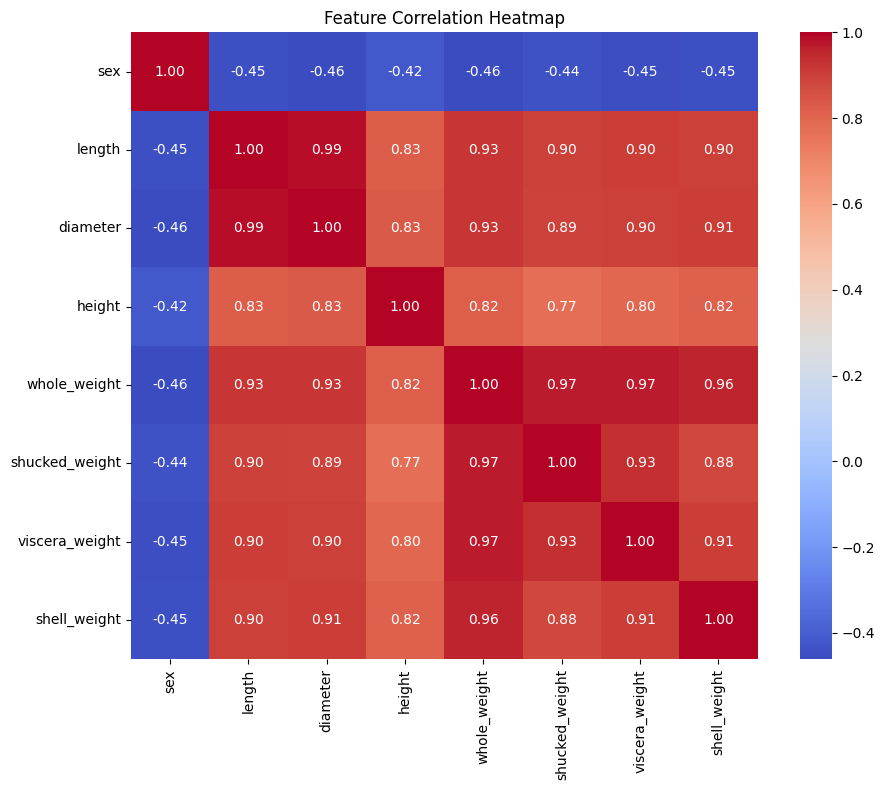

In [ ]:
#Investigating multicollinearity
print(X.columns)

#Mapping categorical variable to avoid multicollinearity amongst itself
X['sex'] = X['sex'].map({'M': 0, 'F': 1, 'I': 2})

#add constant to fit for accurate VIF
X = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

#Multicollinearity matrix
plt.figure(figsize=(10, 8))
corr_matrix = X.drop(columns='const').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

#Removing constant after VIF calculation
X = X.drop(columns = ['const'])

I originally ran the VIFs in R. While the numbers in Python are much larger, they resemble a similar pattern in recognizing high multicollinearity in the weight variables and also between length and diameter. I will use the pattern to guide my feature selection process rather than the typical VIF thresholds since Python VIF values seem to be inflated. Also the constant was added to mediate the extreme values and was removed after.

In [ ]:
#Even though we see high multicollinearity, let's run a regression on the whole model to compare to later

#First we turn sex into a numerical variable
X = pd.get_dummies(X, columns = ['sex'], drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
lin_model_whole = LinearRegression()
lin_model_whole.fit(X_train, y_train)

y_pred_whole_train = lin_model_whole.predict(X_train)
y_pred_whole_test = lin_model_whole.predict(X_test)

#Evaluating whole model performance on training set
mse_whole_train = mean_squared_error(y_train, y_pred_whole_train)
rmse_whole_train = np.sqrt(mse_whole_train)
r2_whole_train = r2_score(y_train, y_pred_whole_train)
print("Whole model training RMSE: " + str(rmse_whole_train))
print("Whole model training R2: " + str(r2_whole_train))

#Evaluating whole model performance on test set
mse_whole_test = mean_squared_error(y_test, y_pred_whole_test)
rmse_whole_test = np.sqrt(mse_whole_test)
r2_whole_test = r2_score(y_test, y_pred_whole_test)
print("Whole model testing RMSE: " + str(rmse_whole_test))
print("Whole model testing R2: " + str(r2_whole_test))

Whole model training RMSE: 2.1941215591356333
Whole model training R2: 0.5433882652503234
Whole model testing RMSE: 2.183479244868033
Whole model testing R2: 0.5130865452704279


We see high multicollinearity in whole weight. This makes intuitive sense since it would be the combined total of the other weight variables. Thus, we should try removing the other weight variables.

Additionally, we can avoid multicollinearity between length, diameter, and height if we create a new variable of volume that is the product of the three. This should be a good approximation since length and diameter are perpendicular as told by the dataset information in UCIML.

Let's run our tests and regressions after changing these features.

In [ ]:
#Aiming for estimation of true model with feature selection
X.rename(columns = {'sex_1': 'female', 'sex_2': 'infant'}, inplace = True)
X_true = X.copy()

X_true['volume'] = X_true['length'] * X_true['diameter'] * X_true['height']
X_true.drop(columns = ['length', 'diameter', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X_true, y, test_size = 0.2, random_state = 1)
lin_model_true = LinearRegression()
lin_model_true.fit(X_train, y_train)

y_pred_true_train = lin_model_true.predict(X_train)
y_pred_true_test = lin_model_true.predict(X_test)

#Evaluating revised model on training set
mse_true_train = mean_squared_error(y_train, y_pred_true_train)
rmse_true_train = np.sqrt(mse_true_train)
r2_true_train = r2_score(y_train, y_pred_true_train)
print("Revised model training RMSE: " + str(rmse_true_train))
print("Revised model training R2: " + str(r2_true_train))

#Evaluating revised model on test set
mse_true_test = mean_squared_error(y_test, y_pred_true_test)
rmse_true_test = np.sqrt(mse_true_test)
r2_true_test = r2_score(y_test, y_pred_true_test)
print("Revised model testing RMSE: " + str(rmse_true_test))
print("Revised model testing R2: " + str(r2_true_test))

Revised model training RMSE: 2.6534565945761157
Revised model training R2: 0.332194987413829
Revised model testing RMSE: 2.6059294159606026
Revised model testing R2: 0.30644814793782915


R Squared score for both training and testing is lower than the full model. This is to be expected when removing multicollinear variables since they lead to overfitting.

Let's re-evaluate the VIFs and multicollinearity of our new model.

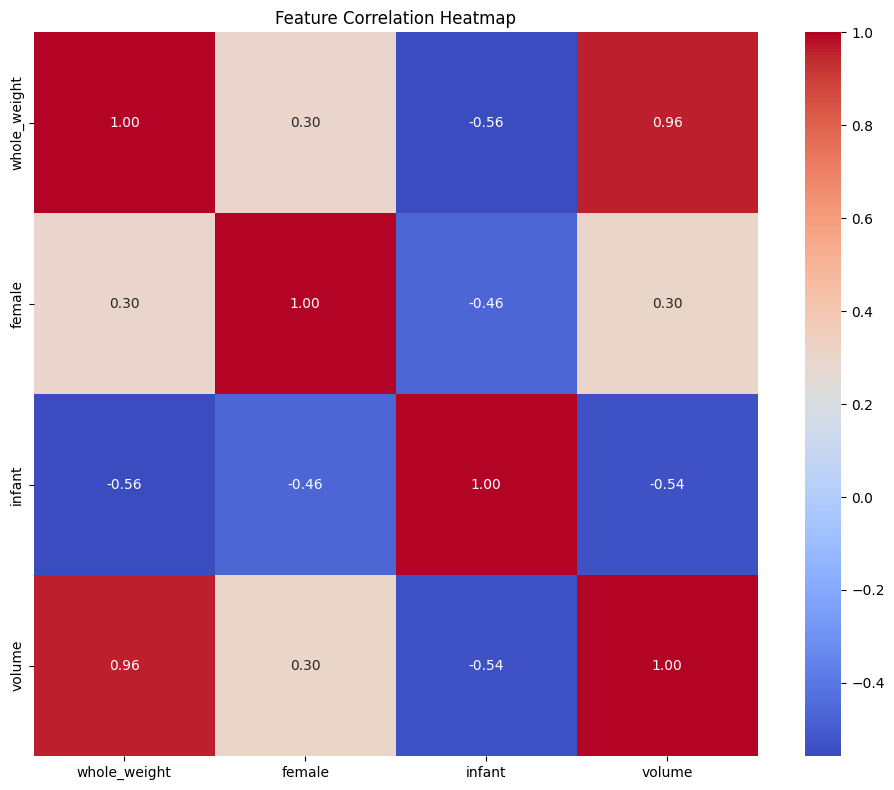

In [ ]:
#Re-evaluating multicollinearity matrix
plt.figure(figsize=(10, 8))
corr_matrix = X_true.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

Though the R squared score is lower with the revised model, the multicollinearity has been reduced significantly. I believe this model is more reflective of the relationship between the feature variables and the target since multicollinearity was inflating the R squared score of the full model.

Now let's try transforming our variables.

In [ ]:
def transform_vars(df, threshold = 0.5):
  numerical_columns = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
  skewed_features = df[numerical_columns].skew()

  for column in skewed_features.index:
    skewness = skewed_features[column]
    if skewness > threshold:
      if skewness > 1:
        df[column] = np.log1p(df[column])
        print(f"Log transformation applied to {column}")
      else:
        df[column] = np.sqrt(df[column])
        print(f"Square root transformation applied to {column}")
  return df

X_transformed = X_true.copy()
X_transformed = transform_vars(X_transformed)
y_transformed = y.copy()
y_transformed = transform_vars(y_transformed)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.2, random_state = 1)
lin_model_transformed = LinearRegression()
lin_model_transformed.fit(X_train, y_train)

y_pred_transformed_train = lin_model_transformed.predict(X_train)
y_pred_transformed_test = lin_model_transformed.predict(X_test)

#Evaluating revised model on training set
mse_transformed_train = mean_squared_error(y_train, y_pred_transformed_train)
rmse_transformed_train = np.sqrt(mse_transformed_train)
r2_transformed_train = r2_score(y_train, y_pred_transformed_train)
print("Transformed model training RMSE: " + str(rmse_transformed_train))
print("Transformed model training R2: " + str(r2_transformed_train))

#Evaluating revised model on test set
mse_transformed_test = mean_squared_error(y_test, y_pred_transformed_test)
rmse_transformed_test = np.sqrt(mse_transformed_test)
r2_transformed_test = r2_score(y_test, y_pred_transformed_test)
print("Transformed model testing RMSE: " + str(rmse_transformed_test))
print("Transformed model testing R2: " + str(r2_transformed_test))

Square root transformation applied to whole_weight
Square root transformation applied to volume
Log transformation applied to rings
Transformed model training RMSE: 0.21185052553750316
Transformed model training R2: 0.45774259221723357
Transformed model testing RMSE: 0.21118058986006397
Transformed model testing R2: 0.43358538852749007


Transforming the variables (both feature and target) seems to have significantly helped the model.

Let's move onto classification: can we accurately classify abalone by harvestable and non-harvestable? For this project, we can set an arbitrary threshold of age (I am choosing the median rings = 9) to imitate how fishing laws restrict overfishing of abalone by banning the fishing of abalone below a certain age so that reproduction may occur and ecological balance is maintained.

I will test decision tree, random forest, and XGBoost, first without hyperparameter tuning.


Decision tree:
Test accuracy: 0.7619617224880383
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64       274
           1       0.83      0.82      0.82       562

    accuracy                           0.76       836
   macro avg       0.73      0.73      0.73       836
weighted avg       0.76      0.76      0.76       836



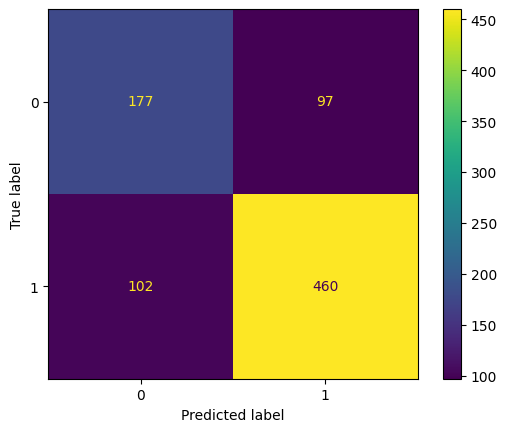


Random forest: 
Test accuracy: 0.8086124401913876
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69       274
           1       0.84      0.88      0.86       562

    accuracy                           0.81       836
   macro avg       0.79      0.77      0.78       836
weighted avg       0.80      0.81      0.81       836



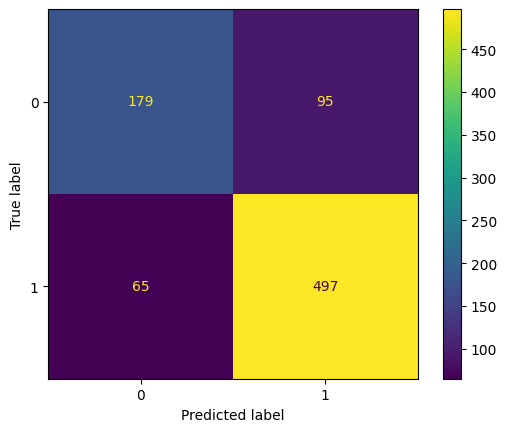


XGBoost: 
Test accuracy: 0.8169856459330144
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70       274
           1       0.84      0.90      0.87       562

    accuracy                           0.82       836
   macro avg       0.80      0.78      0.78       836
weighted avg       0.81      0.82      0.81       836



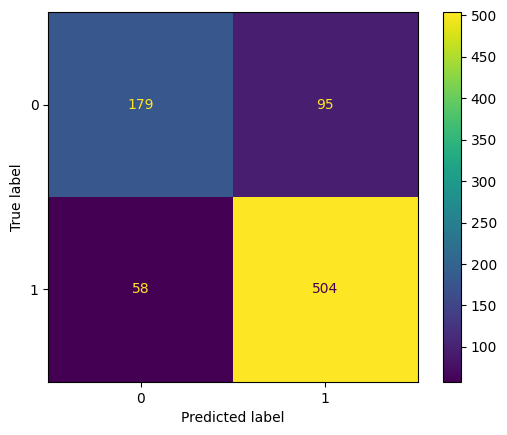

In [ ]:
#Classifying harvestable vs non-harvestable abalone given features
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

#Establishing classes of rings < 8 and rings >= 9 for binary classification
y_binary = (y['rings'] >= 9).astype(int)

X_clf = X_true.copy()

#Train-test split for classification
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(X_clf, y_binary, test_size = 0.2, random_state = 1)

#Decision tree
dt_classifier = DecisionTreeClassifier(random_state=1)
dt_classifier.fit(dt_X_train, dt_y_train)
dt_y_pred_test = dt_classifier.predict(dt_X_test)
print("\nDecision tree:")
print("Test accuracy:", accuracy_score(dt_y_test, dt_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, dt_y_pred_test))
dt_cm = confusion_matrix(dt_y_test, dt_y_pred_test, labels=[0, 1])
dt_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = [0, 1])
dt_cm_display.plot()
plt.show()

#Random forest
rf_classifier = RandomForestClassifier(random_state=1)
rf_classifier.fit(dt_X_train, dt_y_train)
rf_y_pred_test = rf_classifier.predict(dt_X_test)
print("\nRandom forest: ")
print("Test accuracy:", accuracy_score(dt_y_test, rf_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, rf_y_pred_test))
rf_cm = confusion_matrix(dt_y_test, rf_y_pred_test, labels=[0, 1])
rf_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = [0, 1])
rf_cm_display.plot()
plt.show()

#XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
xgb_classifier.fit(dt_X_train, dt_y_train)
xgb_y_pred_test = xgb_classifier.predict(dt_X_test)
print("\nXGBoost: ")
print("Test accuracy:", accuracy_score(dt_y_test, xgb_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, xgb_y_pred_test))
xgb_cm = confusion_matrix(dt_y_test, xgb_y_pred_test, labels=[0, 1])
xgb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = [0, 1])
xgb_cm_display.plot()
plt.show()

Overall, the three methods (decision trees, random forest, and XGBoost) all return similar accuracies. XGBoost and random forest have very similar confusion matrices, with XGBoost performing marginally better in identifying true positives.

The decision tree had the lowest accuracy score, but it is interesting that there is a relatively even amount of false positive and false negative classification errors. Random forest and XGBoost made much more false positive errors than false negatives.

Let's try tuning the hyperparameters to optimize these classification methods, first with grid search.


Decision tree (grid search tuned): 
Best parameters: {'max_depth': 3, 'min_samples_split': 2}
Test accuracy: 0.8241626794258373
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.57      0.68       274
           1       0.82      0.95      0.88       562

    accuracy                           0.82       836
   macro avg       0.83      0.76      0.78       836
weighted avg       0.83      0.82      0.81       836



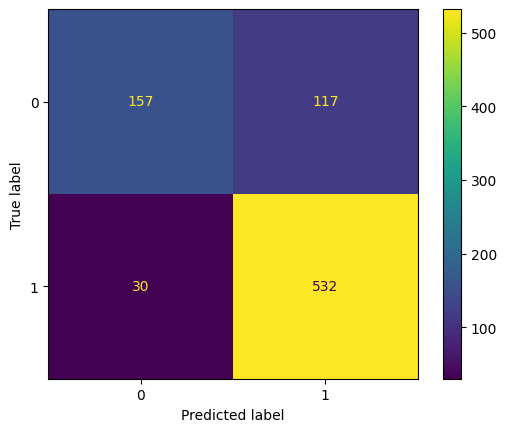


Random forest (grid search tuned): 
Best parameterss: {'max_depth': 5, 'n_estimators': 100}
Test accuracy: 0.8325358851674641
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.65      0.72       274
           1       0.84      0.92      0.88       562

    accuracy                           0.83       836
   macro avg       0.82      0.79      0.80       836
weighted avg       0.83      0.83      0.83       836



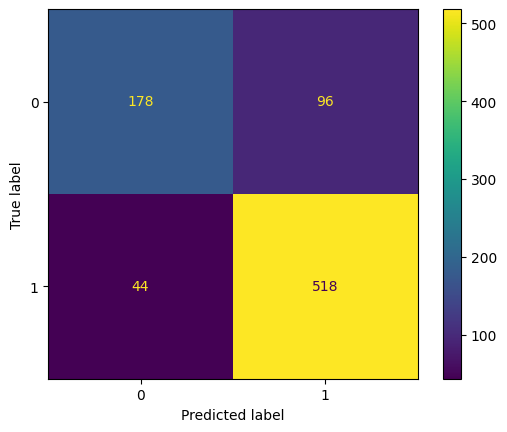


XGBoost (grid search tuned): 
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Test accuracy: 0.8265550239234449
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       274
           1       0.84      0.91      0.88       562

    accuracy                           0.83       836
   macro avg       0.81      0.78      0.79       836
weighted avg       0.82      0.83      0.82       836



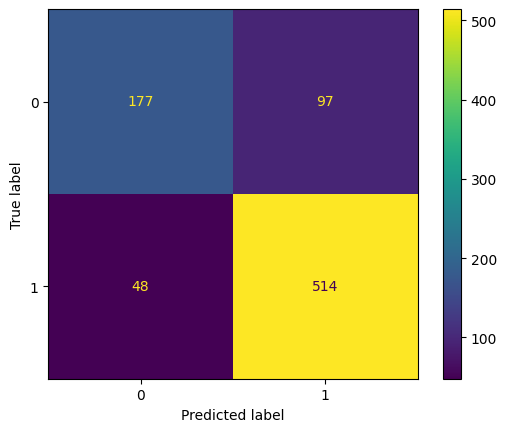

In [ ]:
#Classifying with hyperparameter tuning (Grid search)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore') #tuning XGBoost returned a bunch of warnings

#Establishing classes of rings < 8 and rings >= 9 for binary classification
y_binary = (y['rings'] >= 9).astype(int)

X_clf = X_true.copy()

#Train-test split for classification
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(X_clf, y_binary, test_size = 0.2, random_state = 1)

#Decision tree
dt_params = {
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state = 1), dt_params, cv = 5, scoring = 'accuracy')
dt_grid.fit(dt_X_train, dt_y_train)
dt_best = dt_grid.best_estimator_
dt_y_pred_test = dt_best.predict(dt_X_test)
print("\nDecision tree (grid search tuned): ")
print("Best parameters:", dt_grid.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, dt_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, dt_y_pred_test))
dt_cm = confusion_matrix(dt_y_test, dt_y_pred_test, labels=[0, 1])
dt_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = [0, 1])
dt_cm_display.plot()
plt.show()

#Random forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5, 10, None]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state = 1), rf_params, cv = 5, scoring = 'accuracy')
rf_grid.fit(dt_X_train, dt_y_train)
rf_best = rf_grid.best_estimator_
rf_y_pred_test = rf_best.predict(dt_X_test)
print("\nRandom forest (grid search tuned): ")
print("Best parameterss:", rf_grid.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, rf_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, rf_y_pred_test))
rf_cm = confusion_matrix(dt_y_test, rf_y_pred_test, labels=[0, 1])
rf_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = [0, 1])
rf_cm_display.plot()
plt.show()

#XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 1), xgb_params, cv = 5, scoring = 'accuracy')
xgb_grid.fit(dt_X_train, dt_y_train)
xgb_best = xgb_grid.best_estimator_
xgb_y_pred_test = xgb_best.predict(dt_X_test)
print("\nXGBoost (grid search tuned): ")
print("Best parameters:", xgb_grid.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, xgb_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, xgb_y_pred_test))
xgb_cm = confusion_matrix(dt_y_test, xgb_y_pred_test, labels=[0, 1])
xgb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = [0, 1])
xgb_cm_display.plot()
plt.show()

After grid search hyperparameter tuning, all of the classification methods perform better. The biggest improvement was to the decision tree, even though there were more false positives after tuning. Tuning the hyperparameters significantly reduced the false negatives.

Let's compare the results to tuning with random search.


Decision tree (random search tuned): 
Best parameters: {'min_samples_split': 2, 'max_depth': 3}
Test accuracy: 0.8241626794258373
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.57      0.68       274
           1       0.82      0.95      0.88       562

    accuracy                           0.82       836
   macro avg       0.83      0.76      0.78       836
weighted avg       0.83      0.82      0.81       836



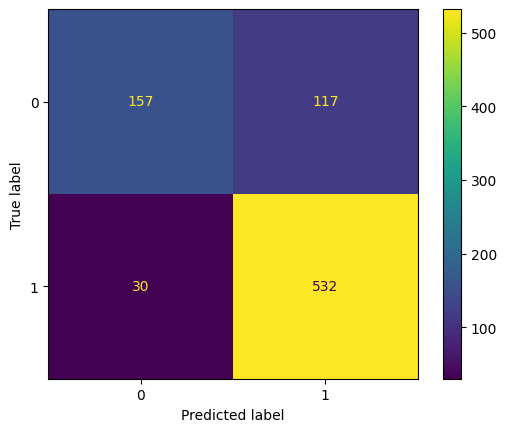


Random forest (random search tuned): 
Best parameters: {'max_depth': 5, 'n_estimators': 118}
Test accuracy: 0.8313397129186603
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.65      0.72       274
           1       0.84      0.92      0.88       562

    accuracy                           0.83       836
   macro avg       0.82      0.78      0.80       836
weighted avg       0.83      0.83      0.83       836



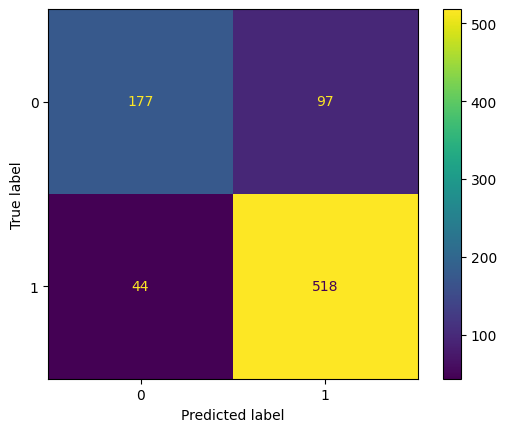


XGBoost (random search tuned): 
Best parameters: {'learning_rate': np.float64(0.25874407221014245), 'max_depth': 3, 'n_estimators': 63}
Test accuracy: 0.8301435406698564
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       274
           1       0.84      0.92      0.88       562

    accuracy                           0.83       836
   macro avg       0.82      0.78      0.80       836
weighted avg       0.83      0.83      0.83       836



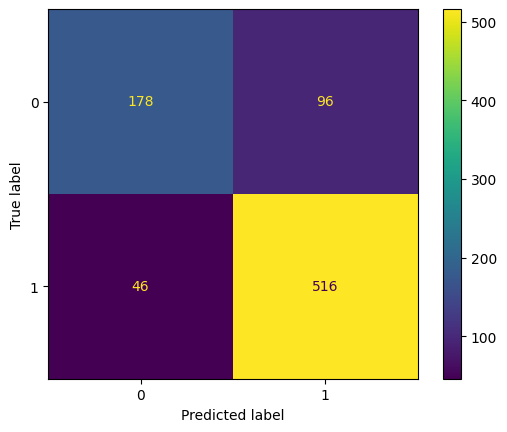

In [ ]:
#Classifying with hyperparameter tuning (Random search)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

#Establishing classes of rings < 8 and rings >= 9 for binary classification
y_binary = (y['rings'] >= 9).astype(int)

X_clf = X_true.copy()

#Train-test split for classification
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(X_clf, y_binary, test_size = 0.2, random_state = 1)

#Decision tree
dt_params = {
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt_rand = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), dt_params, n_iter = 30, cv = 5, scoring = 'accuracy', random_state = 1)
dt_rand.fit(dt_X_train, dt_y_train)
dt_best = dt_rand.best_estimator_
dt_y_pred_test = dt_best.predict(dt_X_test)
print("\nDecision tree (random search tuned): ")
print("Best parameters:", dt_rand.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, dt_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, dt_y_pred_test))
dt_cm = confusion_matrix(dt_y_test, dt_y_pred_test, labels=[0, 1])
dt_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = [0, 1])
dt_cm_display.plot()
plt.show()

#Random forest
rf_params = {
    'n_estimators': randint(50, 150),
    'max_depth': [2, 3, 5, 10, None]
}
rf_rand = RandomizedSearchCV(RandomForestClassifier(random_state = 1), rf_params, n_iter = 30, cv = 5, scoring = 'accuracy', random_state = 1)
rf_rand.fit(dt_X_train, dt_y_train)
rf_best = rf_rand.best_estimator_
rf_y_pred_test = rf_best.predict(dt_X_test)
print("\nRandom forest (random search tuned): ")
print("Best parameters:", rf_rand.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, rf_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, rf_y_pred_test))
rf_cm = confusion_matrix(dt_y_test, rf_y_pred_test, labels=[0, 1])
rf_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = [0, 1])
rf_cm_display.plot()
plt.show()

#XGBoost
xgb_params = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3)
}
xgb_rand = RandomizedSearchCV(XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 1), xgb_params, n_iter = 30, cv = 5, scoring = 'accuracy', random_state = 1)
xgb_rand.fit(dt_X_train, dt_y_train)
xgb_best = xgb_rand.best_estimator_
xgb_y_pred_test = xgb_best.predict(dt_X_test)
print("\nXGBoost (random search tuned): ")
print("Best parameters:", xgb_rand.best_params_)
print("Test accuracy:", accuracy_score(dt_y_test, xgb_y_pred_test))
print("Classification report:\n", classification_report(dt_y_test, xgb_y_pred_test))
xgb_cm = confusion_matrix(dt_y_test, xgb_y_pred_test, labels=[0, 1])
xgb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = [0, 1])
xgb_cm_display.plot()
plt.show()

Random search tuning performed just marginally worse than grid search tuning did.

Conclusions from classification:
Overall, the tree-based methods performed relatively well in being able to correctly classify a given abalone's age from its non-transformed features from the revised model.

The practical use of this would apply to regulations on fishing. Taking batches of caught abalone and using measurements like whole weight, gender, and volume, auditors can check if fishing companies (or individuals) are compliant with fishing regulations. On the fisher's end, it could be used to identify which abalone are ready to be caught and which aren't so they remain compliant with regulations.

In [ ]:
print(X.describe())
print(y['rings'].describe())

       whole_weight       volume
count   4177.000000  4177.000000
mean       0.828742     0.034715
std        0.490389     0.021153
min        0.002000     0.000000
25%        0.441500     0.017911
50%        0.799500     0.032809
75%        1.153000     0.048739
max        2.825500     0.205137
count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: rings, dtype: float64
